In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse.csgraph as csg
from scipy.special import erf
from time import time
matplotlib.rcParams['figure.figsize'] = [7,7]
def gcum(z):
    return (1 + erf(z/np.sqrt(2))) * 0.5

load data for the grid

In [319]:
dim = 2
grid = np.loadtxt("test-5k.grid")[:,0:5]
x = grid[:,0:dim]
ni = np.asarray(grid[:,dim],int)-1
pi = grid[:,dim+1]
ei = grid[:,dim+2]
ncls = np.max(ni)+1
ngrid = len(ni)

computes distance matrix

In [320]:
x2 = np.sum(x**2,axis=1)
dm = -2*np.dot(x,x.T)+np.add.outer(x2,x2)

standard loop over grid points

In [199]:
start = time()
lborder = []
for i in xrange(ngrid):
    for j in xrange(i):
        if ni[i] == ni[j]: continue  # only bother if these are from different clusters
        # check if i and j are Gabriel neighbors        
        dij = dm[i,j]
        lclose = np.intersect1d(np.where(dm[i,:]<dij),np.where(dm[j,:]<dij))
        isgab = True
        for k in lclose:
            if k == i or k == j : continue
            if dm[i,k] + dm[j,k] < dij:
                isgab = False
                break
        if isgab: 
            lborder.append(i)
            lborder.append(j)
lborder = np.unique(np.asarray(lborder,int))
ltime = time()-start

accelerated loop using cluster adjacencies

gets clusters modes, and cluster radii

In [322]:
lcls = []
imod = np.zeros(ncls,int)
pmod = np.zeros(ncls,float)
dmod = np.zeros((ncls,ncls),float)
for i in xrange(ncls):
    icls = np.where(ni == i)[0]
    lcls.append(icls)
    imod[i] = icls[np.argmax(pi[icls])] # gets index of mode
    pmod[i] = np.exp(pi[imod[i]])
dmod=np.sqrt(np.abs(dm[np.ix_(imod,imod)]))
dmin=np.zeros((ncls,ncls),float) #minimum distance between clusters
dmax = np.zeros((ncls),float) #maximum distance between points in cluster i
for i in xrange(ncls):
    dmax[i] = np.max(dm[np.ix_(lcls[i],lcls[i])].flatten())        
    for j in xrange(i):
        dmin[i,j] = np.min(dm[np.ix_(lcls[i],lcls[j])].flatten())
        dmin[j,i] = dmin[i,j]
dmin=np.sqrt(dmin)    
dmax=np.sqrt(dmax)

In [414]:
start = time()
iborder = []
ijlinks = -np.ones((ncls,ncls,2),int)
plinkij = np.zeros((ncls,ncls))
dborder = {}
for i in xrange(ncls):
    # look for the clusters that may harbor Gabriel neighbors of this    
    for j in xrange(i):
        deltaij = dmin[i,j]**2
        noneigh = False       
        threshij = 1e100
        for k in xrange(ncls):
            if i == k or j==k: continue
            #this is the threshold distance below which there is a cluster that invalidates a GN between clst I and J
            threshij = min(threshij, (dmin[i,k]+dmax[i])**2 + (dmin[j,k]+dmax[j])**2)
            if threshij < deltaij: #if the threshold is smaller than the minimum distance, then we can certainly ignore I and J entirely 
                noneigh = True
                break
        if noneigh: continue
        # these could have a common border so we must look for GNs
        
        isel = lcls[i]
        jsel = lcls[j]
        # most of the time a GN pair will be invalidated by points from close-by clusters, so we'll traverse clusters in that order
        dmij2 = dmin[i]**2 + dmin[j]**2
        ksel = np.argsort(dmij2)
        fpij = 1.0
        bordij = []
        for ii in isel:
            if min(dm[ii][jsel]) > threshij: continue
            for jj in jsel:
                dij = dm[ii,jj]
                if dij > threshij: continue # there will be a cluster that certainly voids this GN pair
                isgab = True
                for k in ksel:              
                    # no need to check if the minimum distances are larger
                    if dmij2[k] > dij: continue
                    for kk in lcls[k]:
                        if dm[ii,kk]>dij or dm[jj,kk]>dij: continue
                        if kk == ii or kk == jj : continue
                        if dm[ii,kk] + dm[jj,kk] < dij:
                            isgab = False
                            break
                    if not isgab: break
                if isgab: 
                    iborder.append(ii)
                    iborder.append(jj)
                    bordij.append((ii,jj))
                    pij = (np.exp(pi[ii]) + np.exp(pi[jj])) * 0.5
                    if ijlinks[i,j].sum() < 0 : # first link found                        
                        ijlinks[i,j] = [ii,jj]
                    else:                                                
                        oii, ojj = ijlinks[i,j]
                        opij = (np.exp(pi[oii]) + np.exp(pi[ojj])) * 0.5                                                
                        if pij > opij:
                            ijlinks[i,j] = [ii,jj]
                    # different strategy. we look for the probability that *any* point is higher than the lowest mode
                    eij = np.sqrt(np.exp(ei[ii])**2 + np.exp(ei[jj])**2) * 0.5
                    mij = min(pmod[i], pmod[j]) 
                    fpij *=  gcum((mij-pij)/eij)
                    # print mij, pij, eij, gcum((mij-pij)/eij), fpij
        dborder[(i,j)] = bordij
        plinkij[j,i] = plinkij[i,j] = 1-fpij                

iborder = np.unique(np.asarray(iborder,int))
itime = time()-start
print itime, len(iborder)

27.3771858215 1191


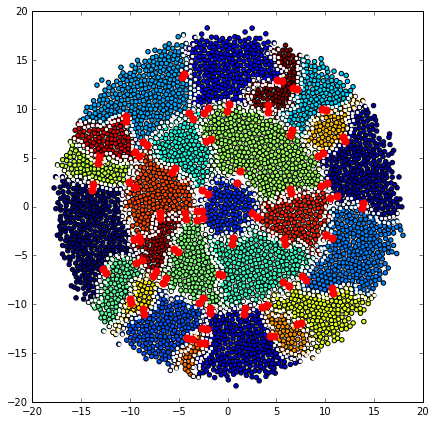

In [371]:
llinks = np.unique(ijlinks.flatten())[1:]
plt.scatter(x[:,0],x[:,1],c=ni)
plt.scatter(x[iborder,0],x[iborder,1],color='white',s=5)
plt.scatter(x[llinks,0],x[llinks,1],color='red',s=50)
plt.axes().set_aspect('equal','datalim')
plt.show()

compute the adjacency coefficients and their uncertainety

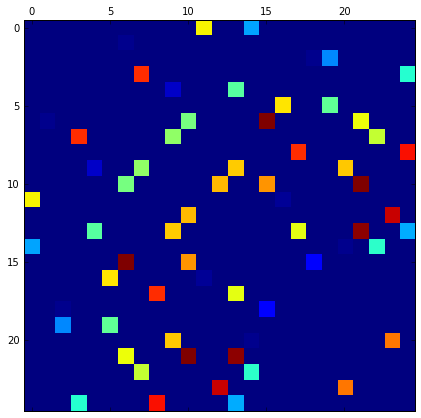

In [394]:
plt.matshow(plinkij)
plt.show()

In [407]:
print plinkij[6,1], aij[6,1], daij[6,1]
print pmod[6], pmod[1], np.exp(ei[imod[6]]), np.exp(ei[imod[1]])
print ijlinks[6,1]
print (np.exp(pi[ijlinks[6,1][0]])+np.exp(pi[ijlinks[6,1][1]]))*0.5
print np.sqrt(np.exp(ei[ijlinks[6,1][0]])**2+np.exp(ei[ijlinks[6,1][1]])**2)*0.5

0.0125839817588 0.951816198448 0.0474363279519
0.00306547483468 0.00308812366706 0.000136266231669 5.74095438096e-05
[1877  654]
0.00291776860359
6.57517210685e-05


In [409]:
print (0.0030654748346-0.00291776860359)
print (0.0030654748346-0.00291776860359)/6.6e-5
print gcum(1), gcum(0), gcum(2)
gcum((0.0030654748346-0.00291776860359)/6.6e-5)

0.00014770623101
2.23797319712
0.841344746069 0.5 0.977249868052


0.98738859847729377

In [416]:
dborder[(6,1)]

[(234, 1909),
 (234, 2287),
 (234, 3001),
 (237, 1835),
 (237, 2896),
 (565, 3001),
 (565, 3942),
 (565, 4614),
 (1488, 3942),
 (1533, 220),
 (1691, 3001),
 (1877, 654),
 (1877, 1909),
 (1877, 4961),
 (1890, 220),
 (1890, 654),
 (1890, 3377),
 (2284, 601),
 (2284, 1445),
 (2285, 732),
 (2285, 2896),
 (2462, 220),
 (2462, 1333),
 (2462, 4062),
 (2462, 4693),
 (3029, 601),
 (3460, 732),
 (3460, 3942),
 (3662, 1445),
 (3757, 1835),
 (3757, 3395),
 (3853, 220),
 (4688, 3942)]

In [435]:
pbk = np.zeros(len(dborder[(6,1)]))
ebk = np.zeros(len(dborder[(6,1)]))
k=0
for ii,jj in dborder[(6,1)]:
    pbk[k] = (np.exp(pi[ii])+np.exp(pi[jj]))*0.5
    ebk[k] = np.sqrt(np.exp(ei[ii])**2+np.exp(ei[jj])**2)*0.5
    k+=1

In [443]:
j=11
prod =1.0
for i in lcls[1]:
    cpi = np.exp(pi[i])
    cei = np.exp(ei[i])
    print cpi-pbk[j], cei, ebk[j], gcum(-(cpi-pbk[j])/np.sqrt(cei**2+ebk[j]**2) )
    prod *= gcum(-(cpi-pbk[j])/np.sqrt(cei**2+ebk[j]**2) ) # prob(i<j)


-0.00291655392372 3.5534731061e-05 6.57517210685e-05 1.0
-0.0028017510205 9.38873492117e-06 6.57517210685e-05 1.0
-0.00291539721767 3.41072699972e-05 6.57517210685e-05 1.0
0.000114602266658 5.94009701047e-05 6.57517210685e-05 0.0979483535243
-0.00287145001518 5.79219057662e-06 6.57517210685e-05 1.0
-0.00286835607743 9.27674339517e-06 6.57517210685e-05 1.0
-0.000250281741557 7.53022908987e-05 6.57517210685e-05 0.993853208723
-0.0028807807877 4.11858870754e-06 6.57517210685e-05 1.0
-0.000586083144701 5.80967984358e-05 6.57517210685e-05 0.999999999988
-0.000916795570121 4.07930024435e-05 6.57517210685e-05 1.0
-0.00262937181849 4.56457525073e-05 6.57517210685e-05 1.0
-0.00246038114698 2.61934808678e-05 6.57517210685e-05 1.0
-0.00278213029355 1.65024781075e-05 6.57517210685e-05 1.0
-0.0027155945338 0.000928258785842 6.57517210685e-05 0.998239480845
-0.000937143351019 7.1765980743e-05 6.57517210685e-05 1.0
-0.0029164575533 1.50369507904e-05 6.57517210685e-05 1.0
-0.00133618902807 0.000120905

In [442]:
prodj = 1
for j in xrange(len(pbk)):
    prod =1.0
    for i in lcls[1]:
        cpi = np.exp(pi[i])
        cei = np.exp(ei[i])
        prod *= gcum(-(cpi-pbk[j])/np.sqrt(cei**2+ebk[j]**2) ) # prob(i<j)
    print j, pbk[j], prod
    prodj *= (1-prod)
print prodj

0 0.0027292028436 2.39703797148e-77
1 0.00249170332316 1.49422053664e-270
2 0.00235780612005 0.0
3 3.14252370799e-05 0.0
4 6.12322714424e-05 0.0
5 0.00165957056905 0.0
6 0.00098112451592 0.0
7 0.00117962410331 0.0
8 0.000639918041836 0.0
9 0.00140022843156 0.0
10 0.00220131765549 0.0
11 0.00291776860359 3.14583226041e-18
12 0.00277704071019 2.17996575311e-60
13 0.00287639209961 1.01457925328e-27
14 0.00199498720159 0.0
15 0.00269516455649 2.65417601605e-87
16 0.00235713729468 0.0
17 0.000284368988638 0.0
18 0.000153694612577 0.0
19 0.000213698651698 0.0
20 0.000107429562426 0.0
21 0.00121512157971 0.0
22 0.000794107259661 0.0
23 0.00104567709901 0.0
24 0.000682961121717 0.0
25 0.000502155169275 0.0
26 0.000318285335432 0.0
27 0.000465045775877 0.0
28 7.82200684768e-05 0.0
29 2.00197634304e-05 0.0
30 8.28182309769e-06 0.0
31 0.00173613349942 0.0
32 0.000872763405826 0.0
1.0


In [430]:
pbk = np.zeros(len(dborder[(9,7)]))
ebk = np.zeros(len(dborder[(9,7)]))
k=0
for ii,jj in dborder[(9,7)]:
    pbk[k] = (np.exp(pi[ii])+np.exp(pi[jj]))*0.5
    ebk[k] = np.sqrt(np.exp(ei[ii])**2+np.exp(ei[jj])**2)*0.5
    k+=1

In [431]:
prodi = 1
for i in lcls[9]:
    cpi = np.exp(pi[i])
    cei = np.exp(ei[i])
    prod = 1
    for j in xrange(len(pbk)):
        prod *= gcum( (cpi-pbk[j])/np.sqrt(cei**2+ebk[j]**2) )
    print cpi, prod
    prodi *= (1-prod)
print 1-prodi

0.000744963376391 0.0969585518005
1.7863089735e-05 8.96484322646e-25
0.00132166853361 0.213647505993
3.85467410419e-05 1.12897347753e-07
0.00300387427045 0.459063505147
0.000864297084899 0.121254310304
3.88725582394e-05 1.29634651781e-21
0.000460528829247 4.35661460269e-06
0.00299303037944 0.0459951157391
3.04444148802e-05 9.85420078205e-32
0.000511343439786 0.0544047723922
0.000266634140374 0.0229898671157
0.00268965700751 0.425833774696
0.00221741716413 0.364612425819
0.00213563938369 0.352208409029
0.00190628949335 0.31602434264
0.000229492157766 0.0196165460288
0.00140695793252 0.229863487046
0.000353693690668 0.0323349215813
0.000100956745018 0.00541946132064
0.000316530897092 0.0276807330292
0.0014506329508 2.72643836033e-06
0.000134090622403 0.0104703847591
0.00024880674185 3.87300546821e-07
0.000101707501151 0.00554956699257
7.57068963964e-05 0.000207610012434
0.00289911836581 0.457804469898
0.00247207055037 0.398847137615
0.00307779545389 0.46733608408
0.00204620361056 0.33410

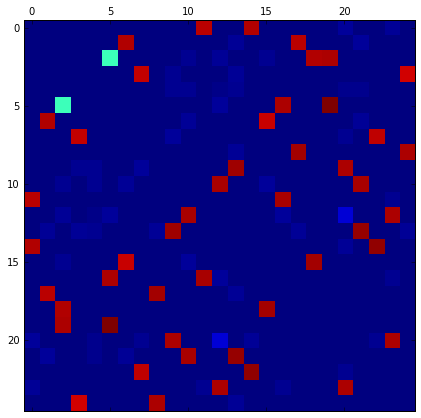

In [327]:
aij = np.zeros((ncls,ncls),float)
daij = np.zeros((ncls,ncls),float)
for i in xrange(ncls):
    for j in xrange(i):
        if ijlinks[i,j].sum() <0: continue
        ii, jj = ijlinks[i,j]
        pij = (np.exp(pi[ii]) + np.exp(pi[jj])) * 0.5
        eij = np.sqrt(np.exp(ei[ii])**2 + np.exp(ei[jj])**2) * 0.5
        # this should be the estimated error on the ratio between probability of saddle and that of the lowest mode
        if pmod[i]<pmod[j]:
            pm = pmod[i]
            em = np.exp(ei[imod[i]])
        else:
            pm = pmod[j]
            em = np.exp(ei[imod[j]])
        r=pij/pm
        er=r*np.sqrt((em/pm)**2+(eij/pij)**2)
        aij[j,i] = aij[i,j] = r
        daij[j,i] = daij[i,j] = er
plt.matshow(aij)
plt.show()

In [378]:
cij = plinkij > 0.5
cgraph=csg.csgraph_from_dense(cij, null_value=False)

In [385]:
print aij[1,6], daij[1,6]

0.951816198448 0.0474363279519


In [393]:
plinkij[1,6]
print np.exp(pi[1877]), np.exp(pi[654])
print pmod[ni[1877]]

0.00285360292186 0.00298193428532
0.00306547483468


In [389]:
ijlinks[6,1]

array([1877,  654])

In [410]:
cij = aij+2*daij>1
cgraph=csg.csgraph_from_dense(cij, null_value=False)

In [411]:
cc=csg.connected_components(cgraph)

In [412]:
macro = []
imacro = np.ones(ngrid)*-1
for i in xrange(cc[0]):
    mci = np.zeros(0,int)
    for j in xrange(ncls):
        if cc[1][j] == i:
            mci = np.union1d(mci, lcls[j])
            imacro[lcls[j]] = i
    macro.append(mci)

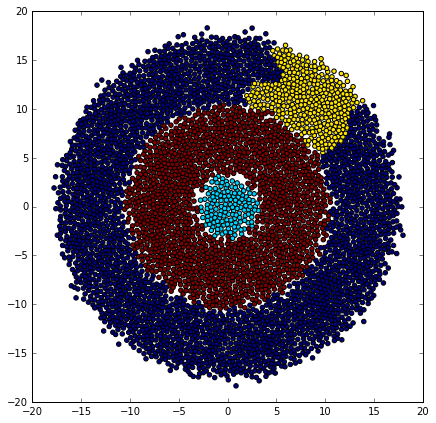

In [413]:
plt.scatter(x[:,0],x[:,1],c=imacro)
plt.axes().set_aspect('equal','datalim')
plt.show()

# ALL NEW

In [90]:
dim = 2
grid = np.loadtxt("test-multi.grid")[:,0:5]
x = grid[:,0:dim]
ni = np.asarray(grid[:,dim],int)-1
pi = grid[:,dim+1]
ei = grid[:,dim+2]
ncls = np.max(ni)+1
ngrid = len(ni)

In [91]:
lcls = []
Qi = np.zeros(ncls)
for i in xrange(ncls):
    icls = np.where(ni == i)[0]
    Qi[i] = np.exp(pi[icls]).sum()
    lcls.append(icls)

In [92]:
nbs = 100
nibs = np.zeros((nbs,ngrid),int)
nclsbs = np.zeros(nbs,int)
for bs in xrange(nbs):
    idx = "%03d" % (bs+1)
    nibs[bs] = np.asarray(np.loadtxt("test-multi-bs"+idx+".grid")[:,2],int) - 1
    nclsbs[bs] = np.max(nibs[bs])+1

IOError: [Errno 2] No such file or directory: 'test-multi-bs001.grid'

In [54]:
QAi = np.zeros((nbs,np.max(nclsbs),ncls))
for bs in xrange(nbs):
    for i in xrange(nclsbs[bs]):
        icls = np.where(nibs[bs] == i)[0]
        for j in xrange(ncls):
            inter = np.intersect1d(icls, lcls[j])
            QAi[bs,i,j] = np.exp(pi[inter]).sum()

In [55]:
aij = np.zeros((ncls,ncls))
for i in xrange(ncls):
    for j in xrange(i+1):
        tij = 0
        for bs in xrange(nbs):
            for k in xrange(nclsbs[bs]):
                tij += QAi[bs,k,i] * QAi[bs,k,j]
        aij[i,j] = aij[j,i] = tij/(Qi[i]*Qi[j]*nbs)
print aij.diagonal()
da=aij.diagonal()
gij=aij / np.sqrt(np.multiply.outer(da,da))

[ 0.53830967  0.85225443  0.83208569  0.5923419   0.9664105   0.65685447
  0.79241617  0.54865298  0.78645863  0.60054466  0.79125873  0.96258244
  0.81375488  0.5973151   0.80950375  0.92586482  0.76207518  0.8403915
  0.7257032   0.60451272  0.83461902  0.59805595  0.89032007  0.72714346
  0.79323137  0.66768597  0.85924684  0.72422672  0.96083561  0.87372046
  0.75690062  0.72689182  0.68196221  0.94929485  0.80029533  0.92140431
  0.92801737  0.7131141   0.85522484  0.87984298  0.94394964  0.86272696
  0.7781373   0.83142803  0.85025065  0.81630626  0.76498681]


In [56]:
plt.matshow(gij)
plt.colorbar()
plt.show()

In [85]:
plt.scatter(x[:,0],x[:,1],c=ni)
#plt.scatter(x[lcls[4],0],x[lcls[4],1],color='black',s=5)
plt.axes().set_aspect('equal','datalim')
plt.show()

In [87]:
cij = aij>0.01
cgraph=csg.csgraph_from_dense(cij, null_value=False)
print cgraph
cc=csg.connected_components(cgraph)

  (0, 0)	1.0
  (0, 17)	1.0
  (0, 22)	1.0
  (0, 40)	1.0
  (1, 1)	1.0
  (1, 11)	1.0
  (1, 30)	1.0
  (2, 2)	1.0
  (2, 16)	1.0
  (2, 18)	1.0
  (2, 33)	1.0
  (2, 43)	1.0
  (3, 3)	1.0
  (3, 19)	1.0
  (3, 29)	1.0
  (3, 37)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (5, 16)	1.0
  (5, 20)	1.0
  (5, 35)	1.0
  (5, 43)	1.0
  (6, 6)	1.0
  (6, 14)	1.0
  (6, 34)	1.0
  :	:
  (41, 41)	1.0
  (41, 46)	1.0
  (42, 10)	1.0
  (42, 24)	1.0
  (42, 26)	1.0
  (42, 42)	1.0
  (42, 46)	1.0
  (43, 2)	1.0
  (43, 5)	1.0
  (43, 16)	1.0
  (43, 33)	1.0
  (43, 35)	1.0
  (43, 43)	1.0
  (44, 13)	1.0
  (44, 25)	1.0
  (44, 44)	1.0
  (45, 6)	1.0
  (45, 14)	1.0
  (45, 18)	1.0
  (45, 45)	1.0
  (46, 23)	1.0
  (46, 26)	1.0
  (46, 41)	1.0
  (46, 42)	1.0
  (46, 46)	1.0


In [88]:
macro = []
imacro = np.ones(ngrid)*-1
for i in xrange(cc[0]):
    mci = np.zeros(0,int)
    for j in xrange(ncls):
        if cc[1][j] == i:
            mci = np.union1d(mci, lcls[j])
            imacro[lcls[j]] = i
    macro.append(mci)
print imacro

[ 0.  0.  0. ...,  2.  0.  0.]


In [89]:
plt.scatter(x[:,0],x[:,1],c=imacro)
plt.axes().set_aspect('equal','datalim')
plt.show()

In [14]:
plt.plot(np.log(np.sort(gij.flatten())))
plt.plot(np.log(np.sort(aij.flatten())))
plt.show()

/home/meissner/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/meissner/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [678]:
np.exp(-7)

0.00091188196555451624

In [613]:
gij.diagonal()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])